---
title: IDs from Juno
order: 10
---

See following notebooks for details:

- [Magnetic field data](./mag.ipynb)
- [State data](./state.ipynb)

## Background

Spacecraft-Solar equatorial

https://pds-ppi.igpp.ucla.edu/data/JNO-SS-3-FGM-CAL-V1.0/INDEX/INDEX.TAB


```txt
------------------------------------------------------------------------------
Juno Mission Phases                                                           
------------------------------------------------------------------------------
Start       Mission                                                           
Date        Phase                                                             
==============================================================================
2011-08-05  Launch                                                            
2011-08-08  Inner Cruise 1                                                    
2011-10-10  Inner Cruise 2                                                    
2013-05-28  Inner Cruise 3                                                    
2013-11-05  Quiet Cruise                                                      
2016-01-05  Jupiter Approach                                                  
2016-06-30  Jupiter Orbital Insertion                                         
2016-07-05  Capture Orbit                                                     
2016-10-19  Period Reduction Maneuver                                         
2016-10-20  Orbits 1-2                                                        
2016-11-09  Science Orbits                                                    
2017-10-11  Deorbit
```

### Coordinate System of Data

1. **SE (Solar Equatorial)**
    - Code: `se`
    - Resampling options: 
        - Number of seconds (1 or 60): `se_rN[N]s`
        - Resampled 1 hour: `se_r1h`

2. **PC (Planetocentric)**
    - Code: `pc`
    - Resampling options: 
        - Number of seconds (1 or 60): `pc_rN[N]s`
        
3. **SS (Sun-State)**
    - Code: `ss`
    - Resampling options: 
        - Number of seconds (1 or 60): `ss_rN[N]s`
        
4. **PL (Payload)**
    - Code: `pl`
    - Resampling options: 
        - Number of seconds (1 or 60): `pl_rN[N]s`

There are three principal coordinate systems used to represent the data in this archive.

- The SE coordinate system is a Spacecraft- Solar equatorial system and it will be used for cruise data only. 
- The sun-state (ss) and planetocentric (pc) will be used for Earth Fly By (EFB) and Jupiter orbital data. 
- Cartesian representations are used for all three coordinate systems. These coordinate systems are specified relative to a “target body” which may be any solar system object (but for this orbital operations will Jupiter). In what follows we will reference Jupiter as the target body, but, for example, if observations near a satellite (such as Io) are desired in Io-centric coordinates, the satellite Io may be specified as the target body. 

The SE coordinate system is defined using the sun-spacecraft vector as the primary reference vector; sun’s rotation axis as the secondary reference vector (z). The x axis lies along the sun-spacecraft vector, the z axis is in the plane defined by the Sun’s rotation axis and the spacecraft-sun vector. The y axis completes the system.

The ss coordinate system is defined using the instantaneous Jupiter-Sun vector as the primary reference vector (x direction). The X-axis lies along this vector and is taken to be positive toward the Sun. The Jupiter orbital velocity vector is the second vector used to define the coordinate system; the y axis lies in the plane determined by the Jupiter-Sun vector and the velocity vector and is orthogonal to the x axis (very nearly the negative of the velocity vector). The vector cross product of x and y yields a vector z parallel to the northward (upward) normal of the orbit plane of Jupiter. This system is sometimes called a sun-state (ss) coordinate system since its principal vectors are the Sun vector and the Jupiter state vector.

## Setup

In [3]:
from discontinuitypy.datasets import IDsDataset
import polars as pl
from fastcore.utils import walk
from loguru import logger

In [14]:
ts = 1 # unit: seconds
tau = 60 # unit: seconds

data_dir = '../../../data'
dir_path = f'{data_dir}/03_primary/JNO_MAG_ts_{ts}s'
juno_state_path = f'{data_dir}/03_primary/JNO_STATE_ts_3600s.parquet'
vec_cols = ['v_x', 'v_y', 'v_z']

format = 'arrow'
fname = f'events.JNO.ts_{ts}s_tau_{tau}s.{format}'
output_path = f'{data_dir}/05_reporting/{fname}'

In [15]:
plasma_data = pl.scan_parquet(juno_state_path).sort('time')
logger.info(plasma_data.columns)

2024-02-16 17:37:52.962 | INFO     | __main__:<module>:2 - ['radial_distance', 'plasma_density', 'plasma_temperature', 'time', 'model_b_r', 'model_b_t', 'model_b_n', 'v_x', 'v_y', 'v_z', 'plasma_speed', 'B_background_x', 'B_background_y', 'B_background_z']


In [16]:
sorted(list(walk(dir_path)))[-1]

'../../../data/03_primary/JNO_MAG_ts_1s/2016.parquet'

## Check the discontinuity in the last year of Juno cruise phase

In [17]:
mag_path = sorted(list(walk(dir_path)))[-1]
juno_mag_data = pl.scan_parquet(mag_path).drop('X', 'Y', 'Z').sort('time')

ids_ds = (
    IDsDataset(
        mag_data=juno_mag_data,
        plasma_data=plasma_data,
        tau=tau,
        ts=ts,
        vec_cols=vec_cols,
        density_col="plasma_density",
        speed_col="plasma_speed",
        temperature_col="plasma_temperature",
    )
    .find_events(return_best_fit=True)
    .update_candidates_with_plasma_data()
)

16-Feb-24 17:39:18: UserWarning: Ray execution environment not yet initialized. Initializing...
To remove this warning, run the following python code before doing dataframe operations:

    import ray
    ray.init()


2024-02-16 17:39:20,716	INFO worker.py:1724 -- Started a local Ray instance.
16-Feb-24 17:39:21: UserWarning: Distributing <class 'pandas.core.frame.DataFrame'> object. This may take some time.



Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ?

(_deploy_ray_func pid=83313) UserWarning: Traceback (most recent call last):
(_deploy_ray_func pid=83313)   File "/Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/pdpipe/__init__.py", line 85, in <module>
(_deploy_ray_func pid=83313)     from . import skintegrate
(_deploy_ray_func pid=83313)   File "/Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/pdpipe/skintegrate.py", line 20, in <module>
(_deploy_ray_func pid=83313)     from sklearn.base import BaseEstimator
(_deploy_ray_func pid=83313) ModuleNotFoundError: No module named 'sklearn'
(_deploy_ray_func pid=83313) 
(_deploy_ray_func pid=83313) UserWarning: pdpipe: Scikit-learn or skutil import failed. Scikit-learn-dependent pipeline stages will not be loaded.
(_deploy_ray_func pid=83313) UserWarning: Traceback (most recent call last):
(_deploy_ray_func pid=83313)   File "/Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/pdpipe/__init__.py", line 105, in <module>

Estimated completion of line 15:   0%           Elapsed time: 00:00, estimated remaining time: ?

(_deploy_ray_func pid=83316) RuntimeWarning: overflow encountered in exp
(_deploy_ray_func pid=83314) UserWarning: Traceback (most recent call last): [repeated 22x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(_deploy_ray_func pid=83314)   File "/Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/pdpipe/nltk_stages.py", line 19, in <module> [repeated 44x across cluster]
(_deploy_ray_func pid=83314)     from . import skintegrate [repeated 11x across cluster]
(_deploy_ray_func pid=83314)     from sklearn.base import BaseEstimator [repeated 11x across cluster]
(_deploy_ray_func pid=83314) ModuleNotFoundError: No module named 'sklearn' [repeated 11x across cluster]
(_deploy_ray_func pid=83307)  [repeated 24x across cluster]
(_deploy_ray_func pid=83314) UserWarning: pdpipe: Scikit-learn or skutil import fa

2024-02-16 17:45:04.679 | INFO     | discontinuitypy.datasets:plot_candidates:201 - Candidates indices: [2211, 1237, 2403, 1162, 1355, 1402, 682, 2432, 2294, 765, 649, 940, 846, 2040, 451, 2263, 1877, 2379, 1206, 433]


[(<Figure size 1200x500 with 1 Axes>,
  <Axes: title={'center': '\n#Fit# $\\max dB/dt$: -0.05, $R^2$: 0.95, $\\chi^2$: 0.75'}, ylabel='$B$\n[nT LMN]'>),
 (<Figure size 1200x500 with 1 Axes>,
  <Axes: title={'center': '\n#Fit# $\\max dB/dt$: -0.08, $R^2$: 0.88, $\\chi^2$: 0.10'}, ylabel='$B$\n[nT LMN]'>),
 (<Figure size 1200x500 with 1 Axes>,
  <Axes: title={'center': '\n#Fit# $\\max dB/dt$: -0.27, $R^2$: 1.00, $\\chi^2$: 1.13'}, ylabel='$B$\n[nT LMN]'>),
 (<Figure size 1200x500 with 1 Axes>,
  <Axes: title={'center': '\n#Fit# $\\max dB/dt$: 0.01, $R^2$: 0.96, $\\chi^2$: 0.09'}, ylabel='$B$\n[nT LMN]'>),
 (<Figure size 1200x500 with 1 Axes>,
  <Axes: title={'center': '\n#Fit# $\\max dB/dt$: 0.05, $R^2$: 0.99, $\\chi^2$: 0.01'}, ylabel='$B$\n[nT LMN]'>),
 (<Figure size 1200x500 with 1 Axes>,
  <Axes: title={'center': '\n#Fit# $\\max dB/dt$: 0.02, $R^2$: 0.97, $\\chi^2$: 0.01'}, ylabel='$B$\n[nT LMN]'>),
 (<Figure size 1200x500 with 1 Axes>,
  <Axes: title={'center': '\n#Fit# $\\max dB/dt

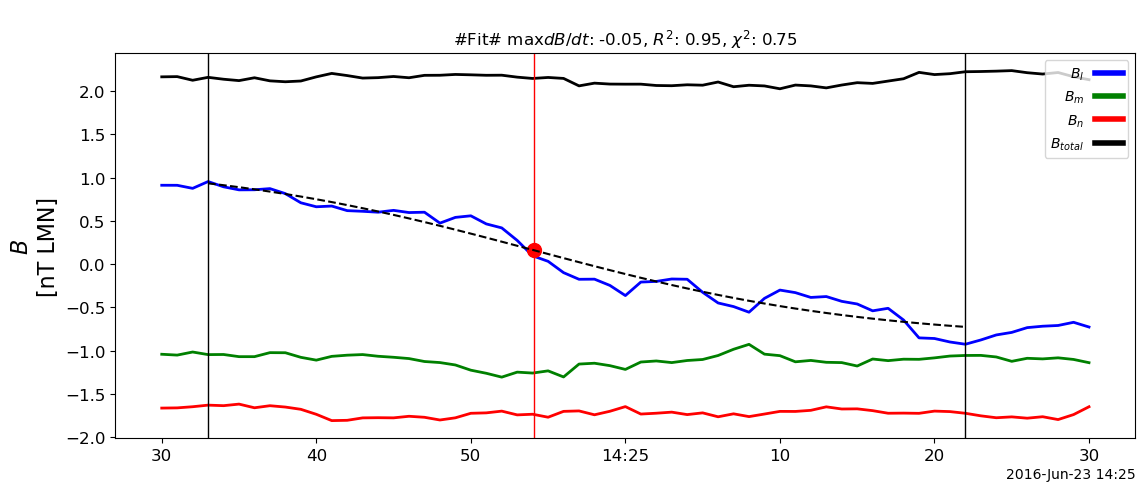

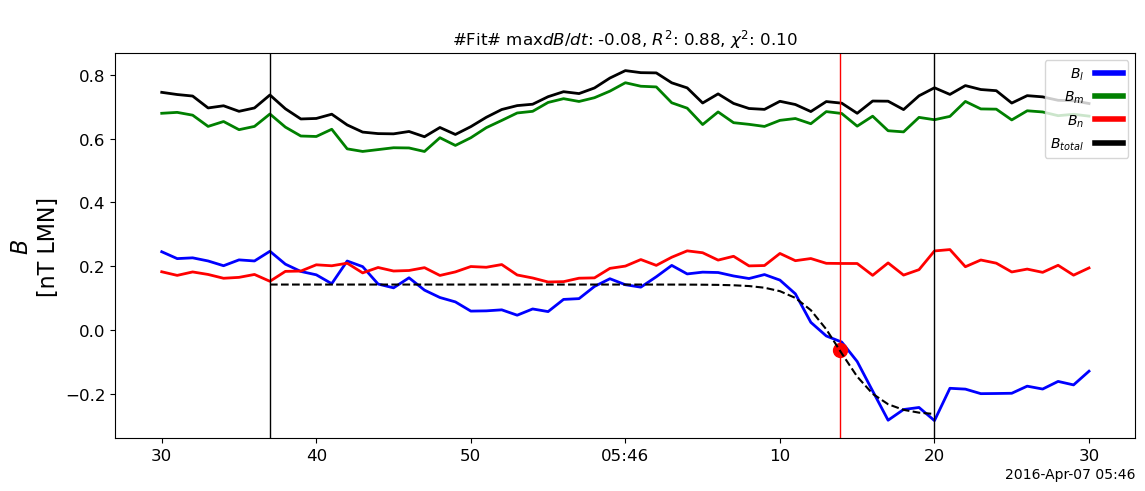

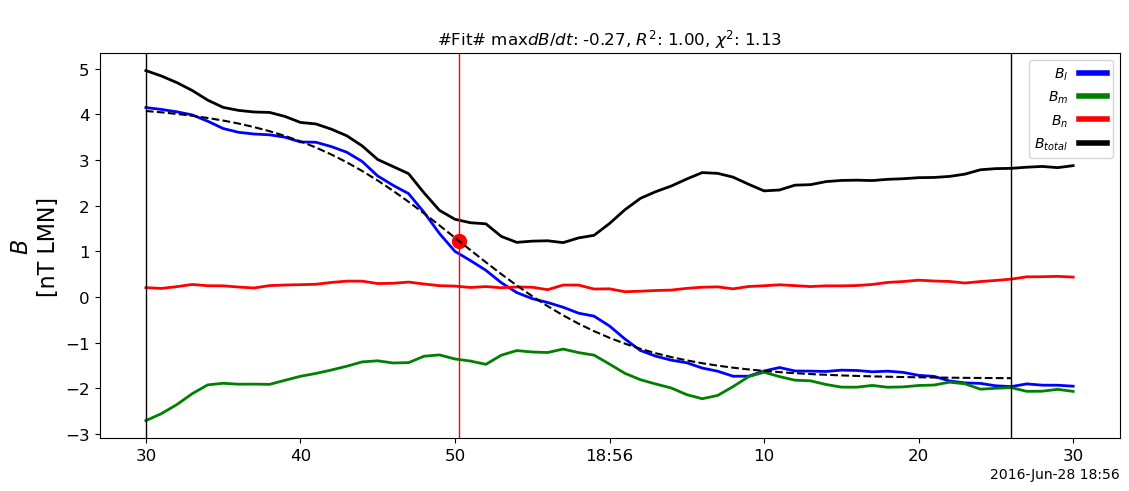

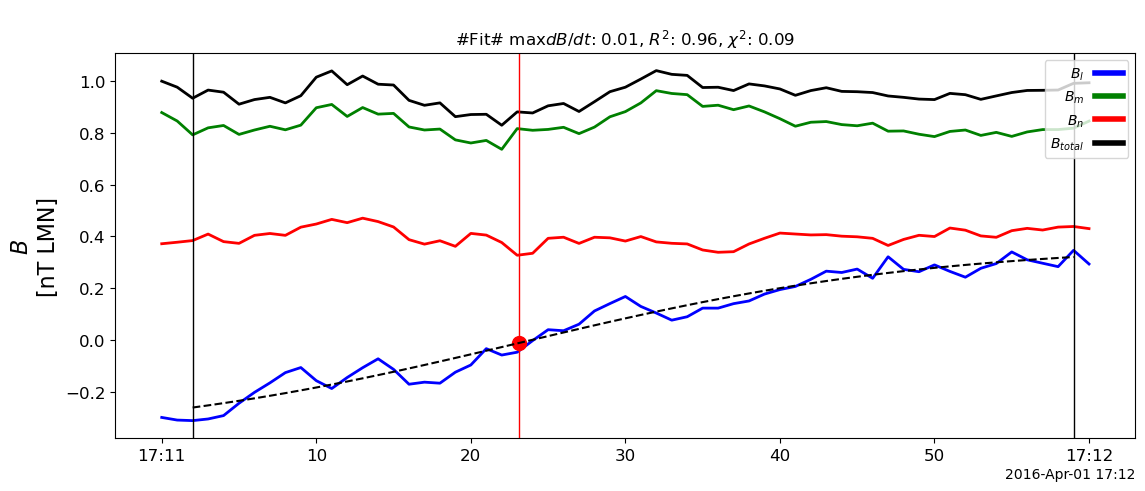

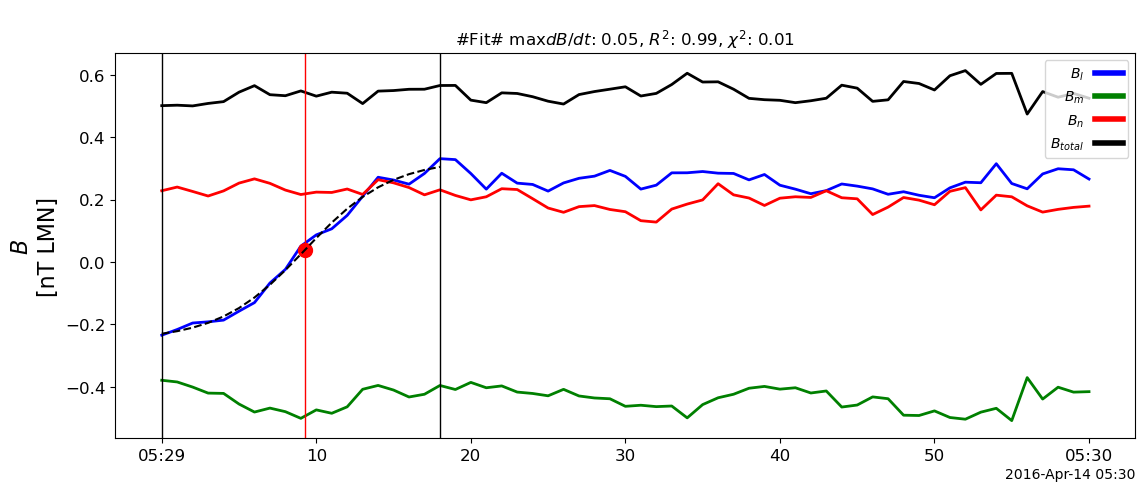

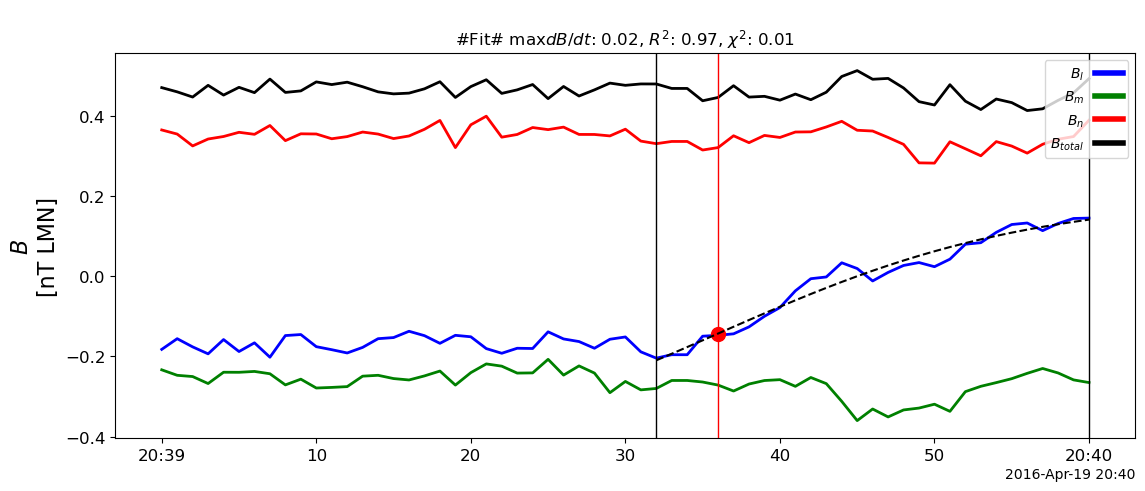

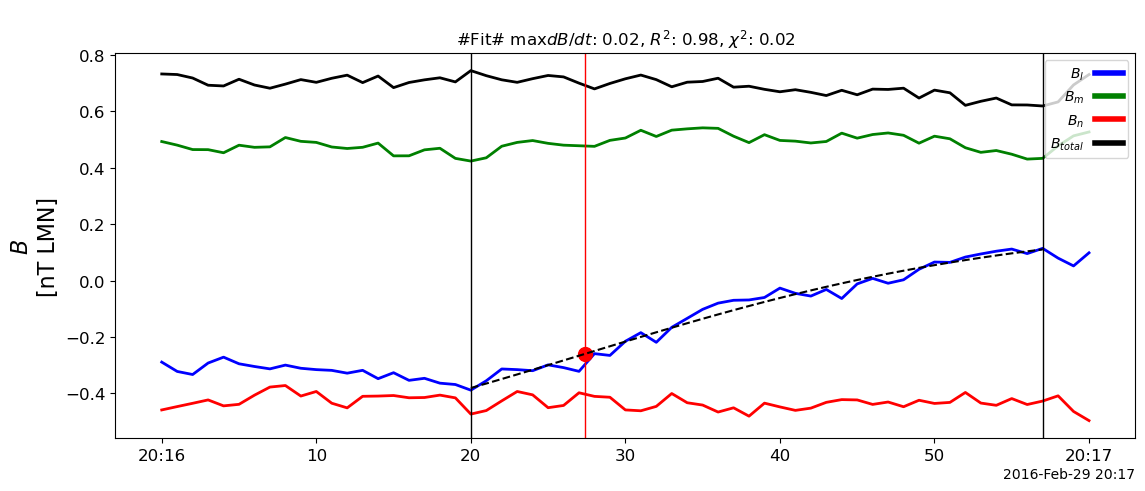

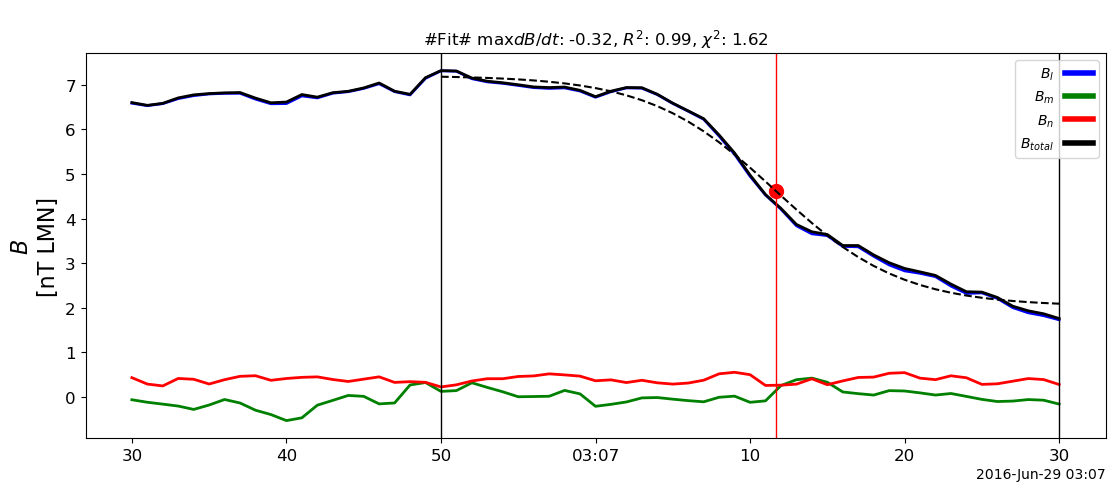

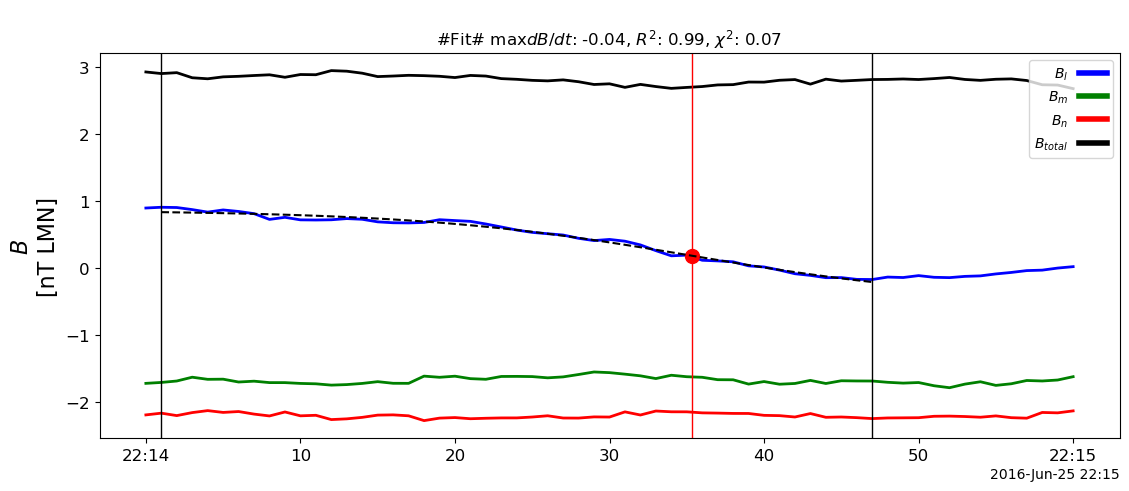

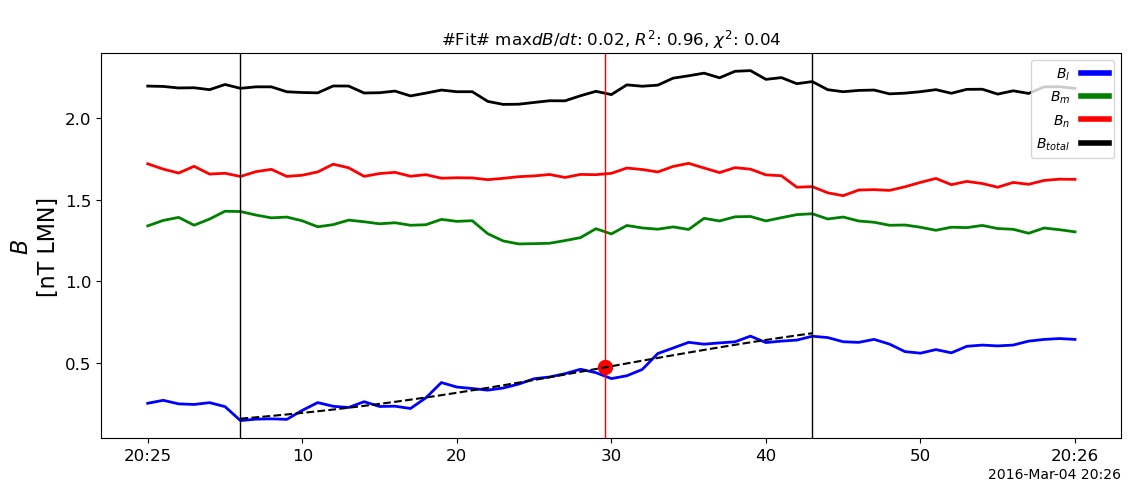

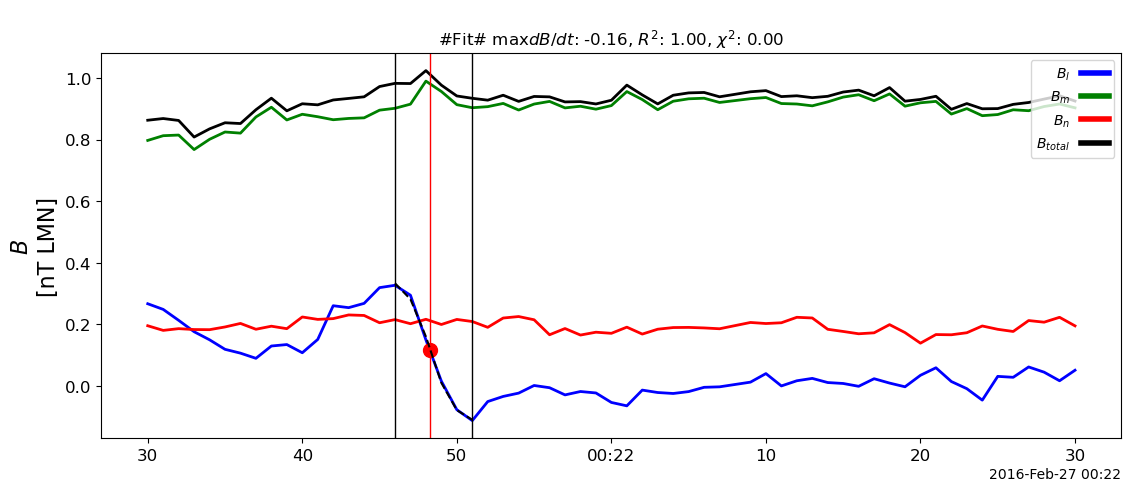

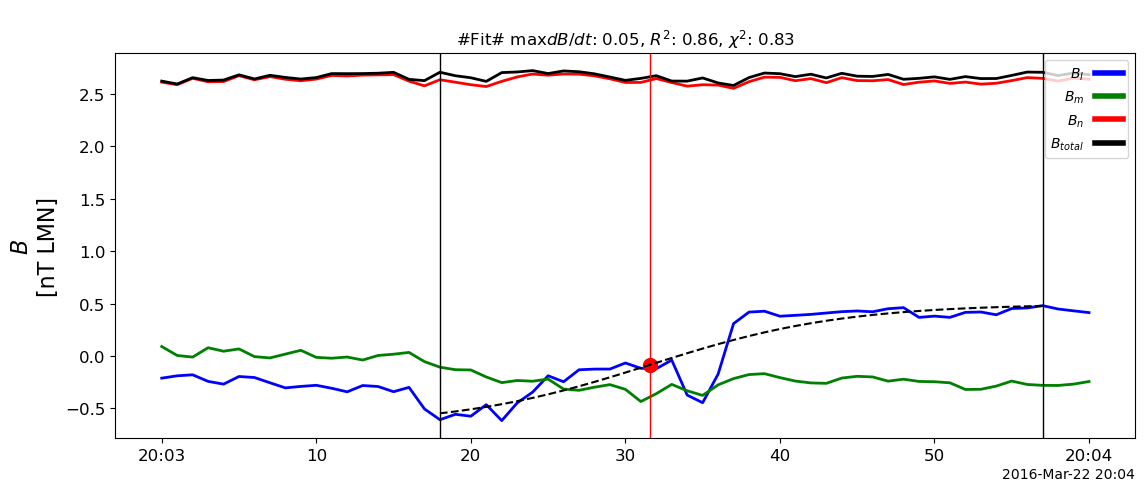

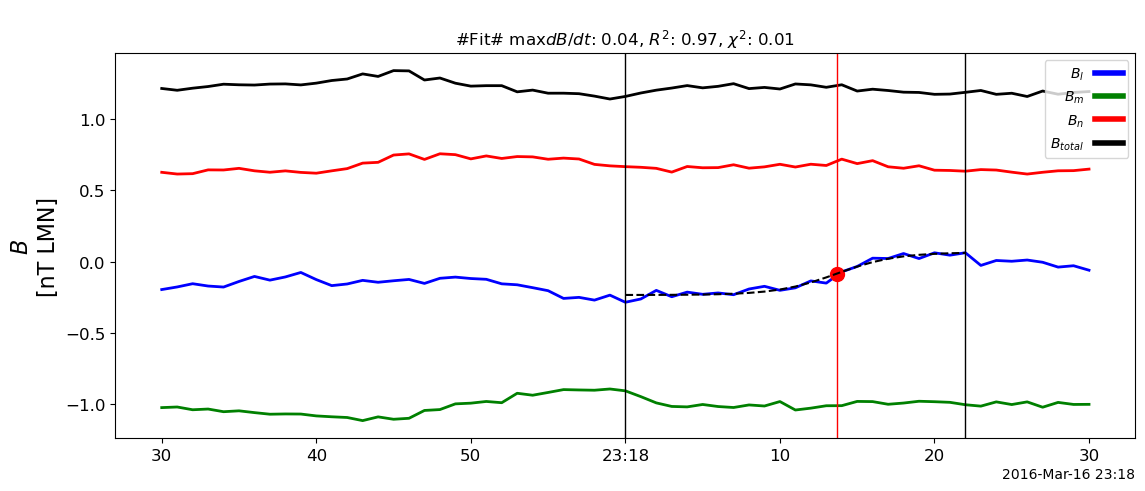

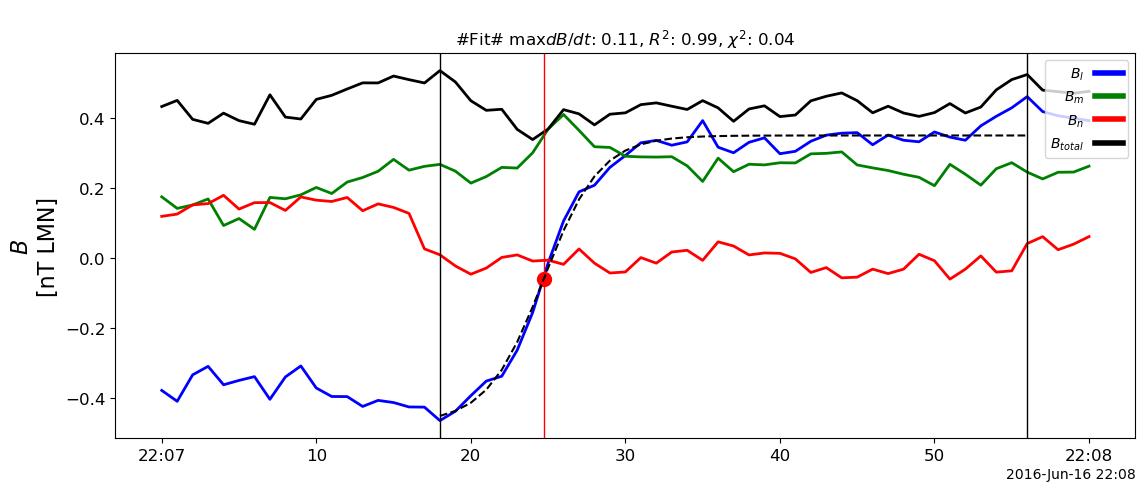

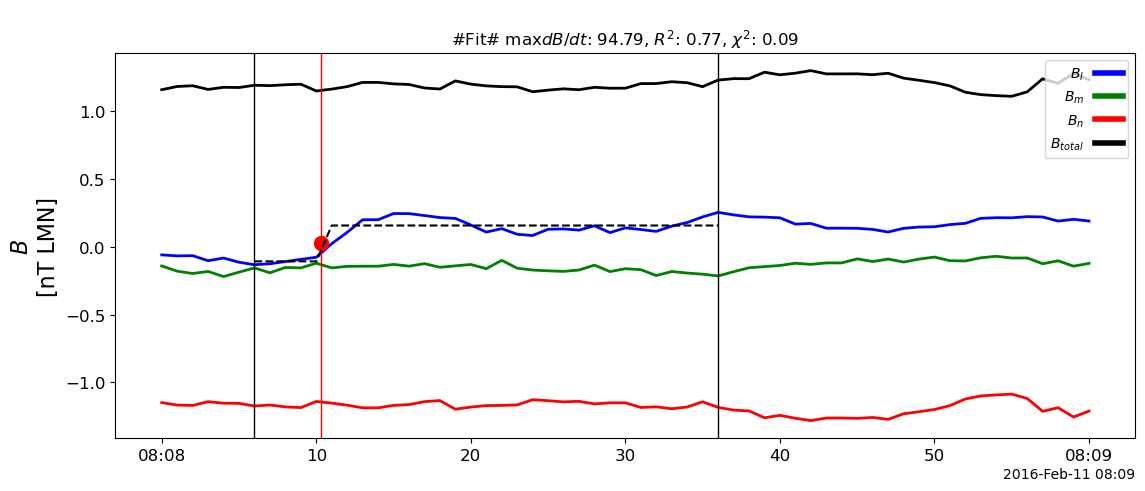

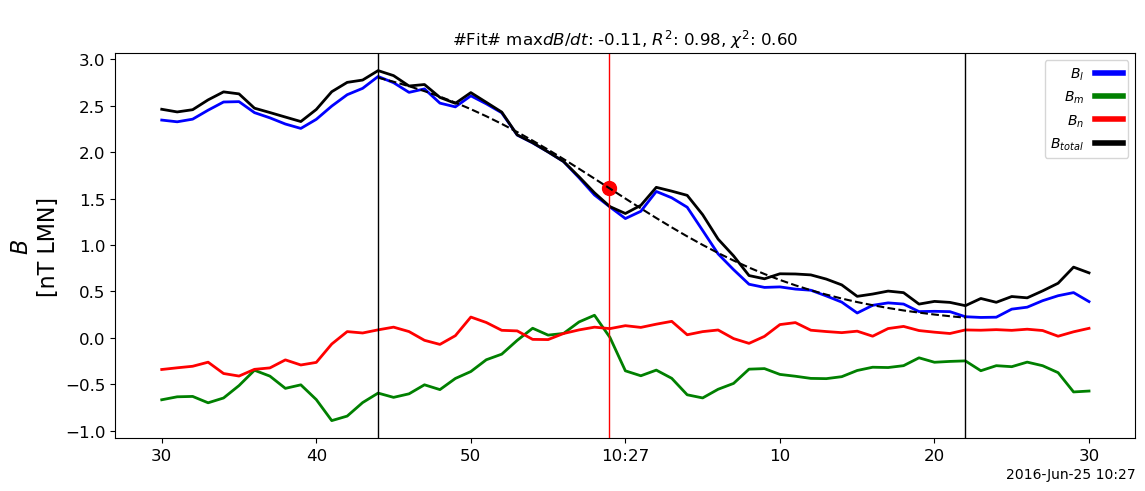

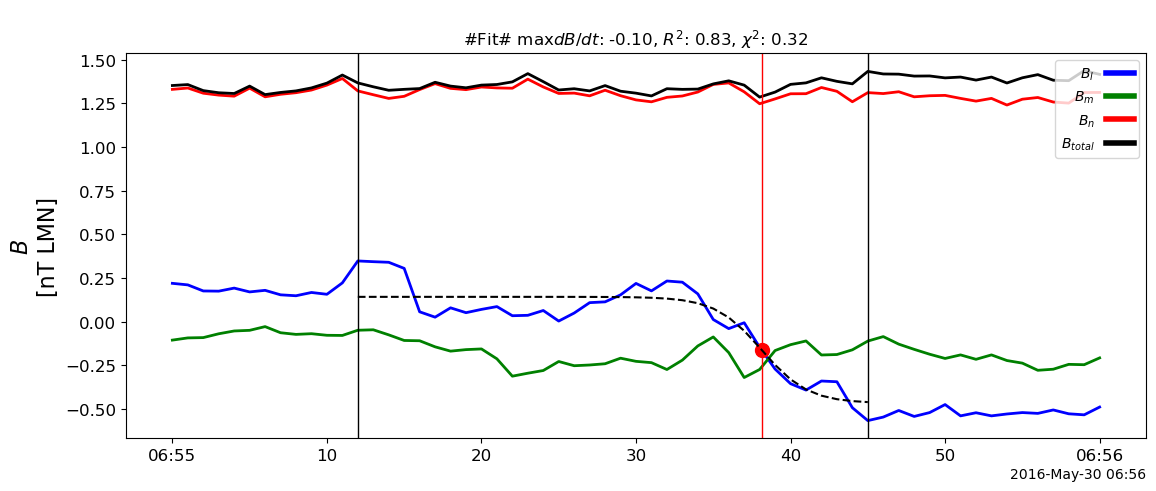

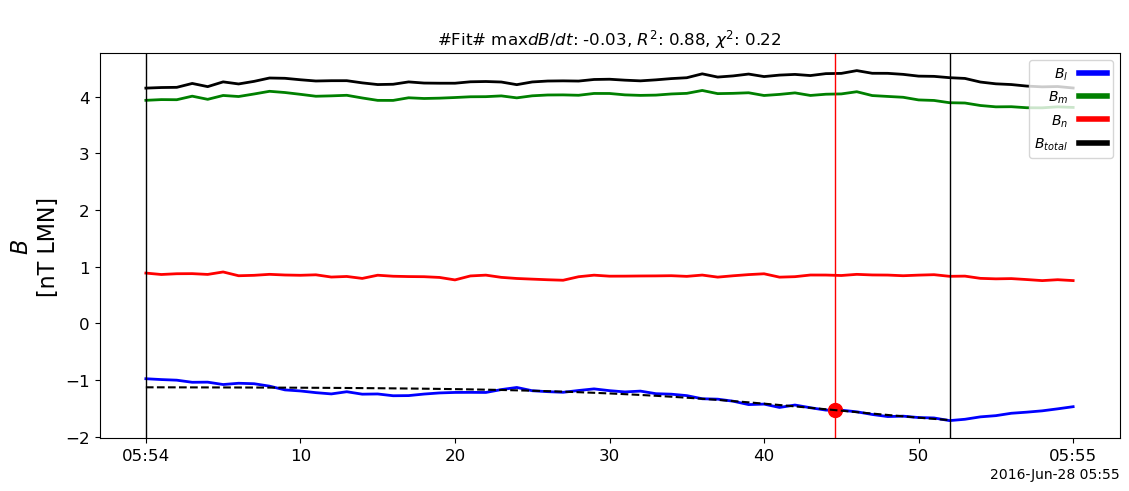

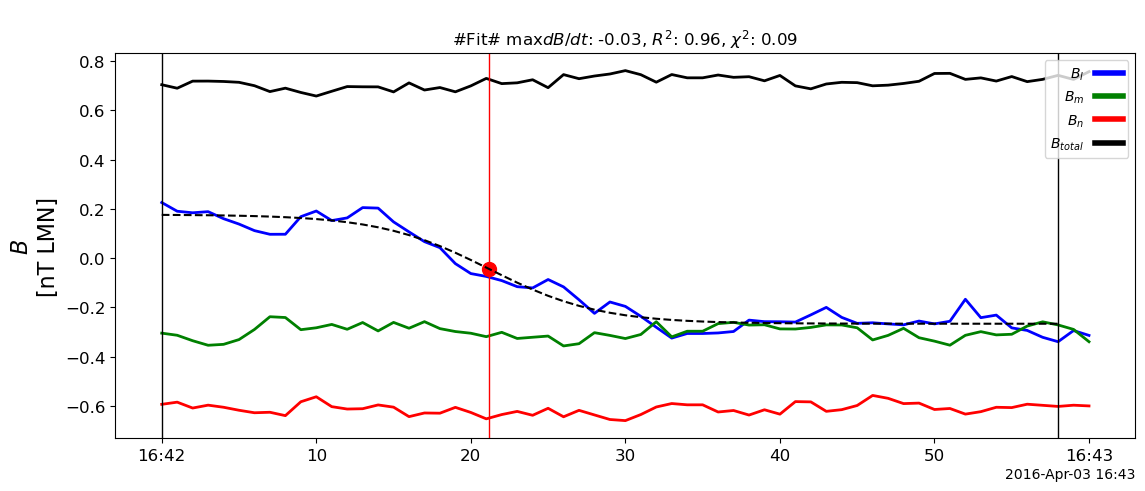

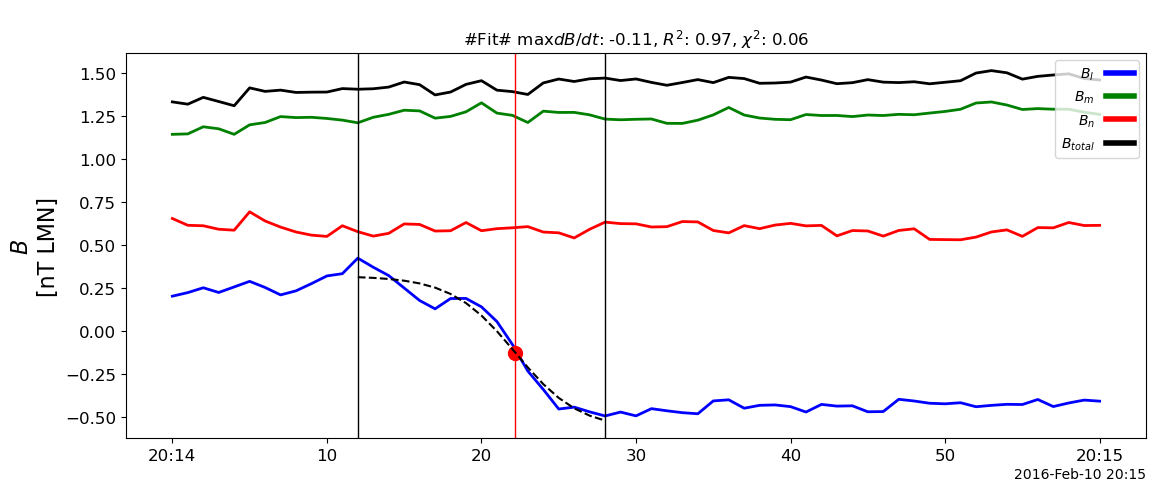

In [25]:
#| layout-ncol="4"
ids_ds.plot_candidates(num=20, plot_fit_data=True)

In [4]:
juno_events = []
for mag_path in walk(dir_path):
    juno_mag_data = pl.scan_parquet(mag_path).drop('X', 'Y', 'Z').sort('time')

    _juno_events = (
        IDsDataset(
            mag_data=juno_mag_data,
            plasma_data=plasma_data,
            tau=tau,
            ts=ts,
            vec_cols=vec_cols,
            density_col="plasma_density",
            speed_col="plasma_speed",
            temperature_col="plasma_temperature",
        )
        .find_events(return_best_fit=False)
        .update_candidates_with_plasma_data()
        .events
    )
    
    juno_events.append(_juno_events)
    
juno_ids_dataset = IDsDataset(
    events=pl.concat(juno_events),
    mag_data= pl.scan_parquet(list(walk(dir_path))).drop('X', 'Y', 'Z').sort('time')
).export(output_path)

09-Feb-24 18:16:00: UserWarning: Ray execution environment not yet initialized. Initializing...
To remove this warning, run the following python code before doing dataframe operations:

    import ray
    ray.init()


2024-02-09 18:16:02,685	INFO worker.py:1724 -- Started a local Ray instance.
09-Feb-24 18:16:04: UserWarning: Distributing <class 'pandas.core.frame.DataFrame'> object. This may take some time.



Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ?

(_deploy_ray_func pid=64713) UserWarning: Traceback (most recent call last):
(_deploy_ray_func pid=64713)   File "/Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/pdpipe/__init__.py", line 85, in <module>
(_deploy_ray_func pid=64713)     from . import skintegrate
(_deploy_ray_func pid=64713)   File "/Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/pdpipe/skintegrate.py", line 20, in <module>
(_deploy_ray_func pid=64713)     from sklearn.base import BaseEstimator
(_deploy_ray_func pid=64713) ModuleNotFoundError: No module named 'sklearn'
(_deploy_ray_func pid=64713) 
(_deploy_ray_func pid=64713) UserWarning: pdpipe: Scikit-learn or skutil import failed. Scikit-learn-dependent pipeline stages will not be loaded.
(_deploy_ray_func pid=64713) UserWarning: Traceback (most recent call last):
(_deploy_ray_func pid=64713)   File "/Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/pdpipe/__init__.py", line 105, in <module>

Estimated completion of line 16:   0%           Elapsed time: 00:00, estimated remaining time: ?

(_deploy_ray_func pid=64713) RuntimeWarning: overflow encountered in exp
(_deploy_ray_func pid=64724) 
(_deploy_ray_func pid=64715) UserWarning: Distributing <class 'dict'> object. This may take some time. [repeated 2771x across cluster]
Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ? [repeated 122x across cluster]
Distributing Dataframe: 100%██████████ Elapsed time: 00:00, estimated remaining time: 00:00 [repeated 2649x across cluster]
Distributing Dataframe: 100%██████████ Elapsed time: 00:00, estimated remaining time: 00:00 [repeated 122x across cluster]
09-Feb-24 18:16:25: UserWarning: Distributing <class 'pandas.core.frame.DataFrame'> object. This may take some time.



Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ?

(_deploy_ray_func pid=64719) RuntimeWarning: overflow encountered in exp [repeated 14x across cluster]
(_deploy_ray_func pid=64722) UserWarning: Distributing <class 'dict'> object. This may take some time.
Distributing Dataframe: 100%██████████ Elapsed time: 00:00, estimated remaining time: 00:00
(_deploy_ray_func pid=64718) UserWarning: Distributing <class 'dict'> object. This may take some time.
Distributing Dataframe: 100%██████████ Elapsed time: 00:00, estimated remaining time: 00:00
Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ?
Distributing Dataframe: 100%██████████ Elapsed time: 00:00, estimated remaining time: 00:00
(_deploy_ray_func pid=64713) 
(_deploy_ray_func pid=64713) UserWarning: Distributing <class 'dict'> object. This may take some time. [repeated 2629x across cluster]
Distributing Dataframe: 100%██████████ Elapsed time: 00:00, estimated remaining time: 00:00 [repeated 2432x across cluster]
Distributing Dataframe:   0%          

Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ?

(_deploy_ray_func pid=64713) UserWarning: Distributing <class 'dict'> object. This may take some time.
Distributing Dataframe: 100%██████████ Elapsed time: 00:00, estimated remaining time: 00:00
(_deploy_ray_func pid=64721) RuntimeWarning: overflow encountered in exp [repeated 4x across cluster]
Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ?
Distributing Dataframe: 100%██████████ Elapsed time: 00:00, estimated remaining time: 00:00
(_deploy_ray_func pid=64717) 
(_deploy_ray_func pid=64722) UserWarning: Distributing <class 'dict'> object. This may take some time. [repeated 2484x across cluster]
Distributing Dataframe: 100%██████████ Elapsed time: 00:00, estimated remaining time: 00:00 [repeated 2356x across cluster]
(_deploy_ray_func pid=64848) RuntimeWarning: overflow encountered in exp [repeated 2x across cluster]
Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ? [repeated 127x across cluster]
Distributing 

Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ?

(_deploy_ray_func pid=64722) UserWarning: Distributing <class 'dict'> object. This may take some time.
(_deploy_ray_func pid=64845) RuntimeWarning: overflow encountered in exp [repeated 5x across cluster]
(_deploy_ray_func pid=64714) UserWarning: Distributing <class 'dict'> object. This may take some time.
Distributing Dataframe: 100%██████████ Elapsed time: 00:00, estimated remaining time: 00:00
Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ?
Distributing Dataframe: 100%██████████ Elapsed time: 00:00, estimated remaining time: 00:00
(_deploy_ray_func pid=64715) 
(_deploy_ray_func pid=64713) UserWarning: Distributing <class 'dict'> object. This may take some time. [repeated 2480x across cluster]
Distributing Dataframe: 100%██████████ Elapsed time: 00:00, estimated remaining time: 00:00 [repeated 2286x across cluster]
Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ? [repeated 194x across cluster]
Distributing

Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ?

(_deploy_ray_func pid=64721) UserWarning: Distributing <class 'dict'> object. This may take some time.
(_deploy_ray_func pid=64957) RuntimeWarning: overflow encountered in exp [repeated 2x across cluster]
Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ?
Distributing Dataframe: 100%██████████ Elapsed time: 00:00, estimated remaining time: 00:00
Distributing Dataframe: 100%██████████ Elapsed time: 00:00, estimated remaining time: 00:00
(_deploy_ray_func pid=64718) 
(_deploy_ray_func pid=64720) UserWarning: Distributing <class 'dict'> object. This may take some time. [repeated 3070x across cluster]
Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ? [repeated 222x across cluster]
Distributing Dataframe: 100%██████████ Elapsed time: 00:00, estimated remaining time: 00:00 [repeated 2856x across cluster]
Distributing Dataframe: 100%██████████ Elapsed time: 00:00, estimated remaining time: 00:00 [repeated 222x across c

Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ?

(_deploy_ray_func pid=64713) UserWarning: Distributing <class 'dict'> object. This may take some time.
Distributing Dataframe: 100%██████████ Elapsed time: 00:00, estimated remaining time: 00:00
(_deploy_ray_func pid=65066) RuntimeWarning: overflow encountered in exp [repeated 18x across cluster]
Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ?
Distributing Dataframe: 100%██████████ Elapsed time: 00:00, estimated remaining time: 00:00
(_deploy_ray_func pid=64716) 
Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ?
(_deploy_ray_func pid=65072) UserWarning: Traceback (most recent call last):
(_deploy_ray_func pid=65072)   File "/Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/pdpipe/__init__.py", line 85, in <module>
(_deploy_ray_func pid=65072)     from . import skintegrate
(_deploy_ray_func pid=65072)   File "/Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/pdpi

## Processing the whole data

## Obsolete

### Estimate

1 day of data resampled by 1 sec is about 12 MB.

So 1 year of data is about 4 GB, and 6 years of JUNO Cruise data is about 24 GB.

Downloading rate is about 250 KB/s, so it will take about 3 days to download all the data.

In [5]:
num_of_files = 6*365
jno_file_size = 12e3
thm_file_size = 40e3
files_size = jno_file_size + thm_file_size
downloading_rate = 250
processing_rate = 1/60

time_to_download = num_of_files * files_size / downloading_rate / 60 / 60
space_required = num_of_files * files_size / 1e6
time_to_process = num_of_files / processing_rate / 60 / 60

print(f"Time to download: {time_to_download:.2f} hours")
print(f"Disk space required: {space_required:.2f} GB")
print(f"Time to process: {time_to_process:.2f} hours")

Time to download: 126.53 hours
Disk space required: 113.88 GB
Time to process: 36.50 hours
